# Introduction

We thought about this project after we have seen the studies of Franz Joseph Gall and Cesare Lombroso in "Cognition and Neuroscience" course about physiognomy. This theory states that the morality of a person could be determined by the physiology of his face. We believe that this theory is unfounded, therefore, with this report, we start the journey to refute it. So, we try to create a binary classifier to determin if a person is a criminal or not only by the photo of his face.
Of course, the goal of this project is only to check if there exixts some forms of correlation between the theories and the results of a practical implementation.

DISCLAIMER: some terms used in this notebook could be considered old and offensive. Those terms are used only because of the existing datasets.

### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
from PIL import Image
import os
from deepface import DeepFace, DeepFaceConv

In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Fix randomicity for reproducibility

In [2]:
seed = 42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed)
np.random.seed(seed)
rand.seed(seed)

# Dataset 1.0

## Starting images

Criminal dataset --> taken from Kaggle: https://www.kaggle.com/datasets/elliotp/idoc-mugshots

Non-Criminal dataset --> Labeled Faces in the Wild (LFW): http://vis-www.cs.umass.edu/lfw/

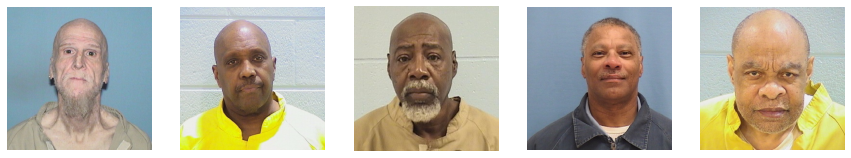

Original criminal images, with sizes: (476, 472) pixels


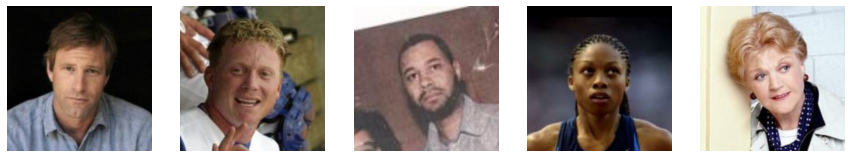

Original lfw images, with sizes: (250, 250) pixels


In [3]:
crim_path = './dataset/original/original_criminal/'
fig = plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(crim_path)):
    fig.add_subplot(1,5,i+1)
    img = Image.open(crim_path + file)
    plt.axis('off')
    plt.imshow(img)
plt.show()
print(f'Original criminal images, with sizes: {img.size} pixels')

lfw_path = './dataset/original/original_lfw/'
fig = plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(lfw_path)):
    fig.add_subplot(1,5,i+1)
    img = Image.open(lfw_path + file)
    plt.axis('off')
    plt.imshow(img)
plt.show()
print(f'Original lfw images, with sizes: {img.size} pixels')

The images are then cropped, frontalized and resized to 152x152 pixels, as required by DeepFace architecture.

This process is done through OpenFace: https://github.com/TadasBaltrusaitis/OpenFace, a toolkit capable of facial landmark detection

The results are the following:

Cropped and aligned criminal images:


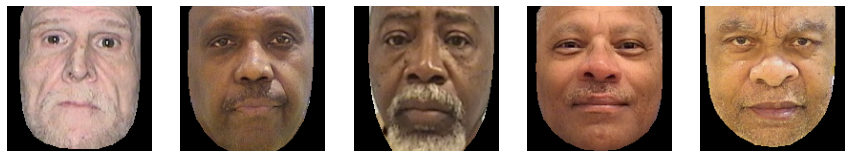

Original sizes: (152, 152) pixels

Cropped and aligned lfw images:


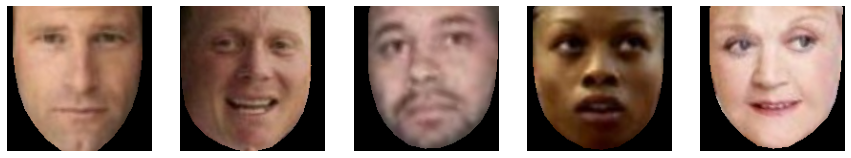

Original sizes: (152, 152) pixels


In [5]:
crim_path = './dataset/cropped/criminal/'
print('Cropped and aligned criminal images:')
fig = plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(crim_path)):
    fig.add_subplot(1,5,i+1)
    img = Image.open(crim_path + file)
    plt.axis('off')
    plt.imshow(img)
plt.show()
print(f'Original sizes: {img.size} pixels')

lfw_path = './dataset/cropped/lfw/'
print('\nCropped and aligned lfw images:')
fig = plt.figure(figsize=(15,15))
for i, file in enumerate(os.listdir(lfw_path)):
    fig.add_subplot(1,5,i+1)
    img = Image.open(lfw_path + file)
    plt.axis('off')
    plt.imshow(img)
plt.show()
print(f'Original sizes: {img.size} pixels')

The images have now the same sizes and the same file dimension (67.7KB)

In [27]:
dir_path = './dataset/aligned/criminal/'
criminal_len = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
dir_path = './dataset/aligned/non-criminal/'
lfw_len = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

print(f'The length of criminal dataset is: {criminal_len}\nThe length of the non-criminal (lfw) dataset is: {lfw_len}')

The length of criminal dataset is 69236
The length of the non-criminal (lfw) dataset is 10712


## Load dataset

We do not consider all the data at our disposal, because there are around 70000 images of criminals and only 10000 images of "non-criminal". With this kind of dataset, predicting always 0 (label for criminal) gives around 90% of accuracy.

### Dataset Little

In [57]:
batch_size = 4
image_size = (152, 152)
train_val_split = 0.2
data_dir = "./dataset/little/"

In [58]:
criminal_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

criminal_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


# Architecture 1.0

First, we ensure ourselves that the architecture we have chosen is the right one for this task. So we tried a simple linear classifier (because this is a binary classification problem) and DeepFace with only standard convolutions.

## Linear Classifier

In [88]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Flatten
from PIL import Image
from datetime import datetime
from keras.callbacks import History, EarlyStopping

# model creation
def create_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

lin_class = create_model()
lin_class.compile(optimizer='SGD',
                  metrics=['accuracy'],
                  loss='binary_crossentropy')

lin_class.build(input_shape=(4,152,152,3))
lin_class.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=True)
callbacks = [early_stopping]

# fit
lin_class.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=10, use_multiprocessing=True, workers=8, callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (4, 69312)                0         
                                                                 
 dense_6 (Dense)             (4, 8)                    554504    
                                                                 
 dense_7 (Dense)             (4, 1)                    9         
                                                                 
Total params: 554,513
Trainable params: 554,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
800/800 [==============================] - 5s 6ms/step - loss: 0.8144 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4825
Epoch 2/10
800/800 [==============================] - 5s 6ms/step - loss: 0.6934 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4825
Epoch 3/10
800/800 [========

As foreseen, the accuracy is always around 50%

## DeepFace

DeepFace is a neural network proposed by Meta researchers in the paper: https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf

![title](images/deepfacearchitecture.JPG)

The innovation of DeepFace is the use of LocallyConnected layers, instead of standard convolutions. In these layers weights are NOT shared across different locations.

![title](images/std_conv.JPG)

![title](images/local_conv.JPG)

(The above images are taken from the slides of Prof. Salti)

### DeepFace with standard convolutions

In [84]:
from deepface import DeepFaceConv

model_conv = DeepFaceConv()
optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.BinaryCrossentropy()
model_conv.compile(optimizer, loss, metrics=['accuracy'])
model_conv.build(input_shape=(4,152,152,3))
model_conv.summary_model()

Model: "DeepFace"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 70, 70, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 62, 62, 16)        41488     
                                                                 
 L4 (Conv2D)                 (None, 54, 54, 16)        20752     
                                                                 
 L5 (Conv2D)                 (None, 24, 24, 16)        12560     
                                                                 
 L6 (Conv2D)                 (None, 20, 20, 16)        641

In [85]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min', restore_best_weights=True)
callbacks = [early_stopping]

In [86]:
model_conv.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=10, use_multiprocessing=True, workers=8, callbacks=callbacks)  # .take(20)

Epoch 1/10
800/800 [==============================] - 87s 106ms/step - loss: 0.8789 - accuracy: 0.4900 - val_loss: 0.6934 - val_accuracy: 0.4825
Epoch 2/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6936 - accuracy: 0.4903 - val_loss: 0.6932 - val_accuracy: 0.4825
Epoch 3/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6955 - accuracy: 0.4947 - val_loss: 0.6958 - val_accuracy: 0.4825
Epoch 4/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6972 - accuracy: 0.4975 - val_loss: 0.6976 - val_accuracy: 0.4825
Epoch 5/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6950 - accuracy: 0.4934 - val_loss: 0.6933 - val_accuracy: 0.4825
Epoch 6/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6950 - accuracy: 0.5084 - val_loss: 0.6946 - val_accuracy: 0.4863
Epoch 7/10
800/800 [==============================] - 22s 28ms/step - loss: 0.6975 - accuracy: 0.5259 - val_loss: 0.6935 - val_accuracy

### DeepFace

We have seen that both Linear Classifier and DeepFace with standard convolutions reach an accuracy around 50%, that is the same of a random classifier. Let's check if the canonical DeepFace architecture is able to obtain better result exploiting LocallyConnected layers.

In [59]:
model = DeepFace()
optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer, loss, metrics=['accuracy'])
model.build(input_shape=(4,152,152,3))
model.summary_model()

Model: "DeepFace"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 70, 70, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 62, 62, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 54, 54, 16)        60512832  
                                                                 
 L5 (LocallyConnected2D)     (None, 24, 24, 16)        7234560   
                                                                 
 L6 (LocallyConnected2D)     (None, 20, 20, 16)        256

In [60]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=True)

callbacks = [early_stopping]

In [61]:
model.fit(criminal_train_ds.take(400), validation_data=criminal_val_ds.take(80), epochs=10, use_multiprocessing=True, workers=8, callbacks=callbacks)  # .take(20)

Epoch 1/10
400/400 [==============================] - 278s 434ms/step - loss: 0.6837 - accuracy: 0.5562 - val_loss: 0.6376 - val_accuracy: 0.6062
Epoch 2/10
400/400 [==============================] - 146s 365ms/step - loss: 0.5991 - accuracy: 0.7344 - val_loss: 0.3388 - val_accuracy: 0.8906
Epoch 3/10
400/400 [==============================] - 144s 360ms/step - loss: 0.4996 - accuracy: 0.7950 - val_loss: 0.3232 - val_accuracy: 0.8562
Epoch 4/10
400/400 [==============================] - 145s 362ms/step - loss: 0.4704 - accuracy: 0.8062 - val_loss: 0.4351 - val_accuracy: 0.8031
Epoch 5/10
400/400 [==============================] - 145s 361ms/step - loss: 0.3599 - accuracy: 0.8575 - val_loss: 0.2340 - val_accuracy: 0.9250
Epoch 6/10
400/400 [==============================] - 145s 363ms/step - loss: 0.2401 - accuracy: 0.9137 - val_loss: 0.1586 - val_accuracy: 0.9187
Epoch 7/10
400/400 [==============================] - 144s 360ms/step - loss: 0.1531 - accuracy: 0.9456 - val_loss: 0.1619 -

The results seem promising, but testing the model on "non-criminal" only images we noticed a big bias: 

1/1 [==============================] - 0s 208ms/step
[1.        0.9999951 0.9694123 0.9621486]


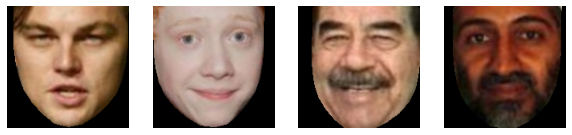

In [80]:
fig = plt.figure(figsize=(10,10))


test_set_1 = tf.Variable(tf.zeros((4,152,152,3)))

img1 = Image.open('./dataset/test/non-criminal/Leonardo_DiCaprio_0001.bmp')
tens1 = tf.convert_to_tensor(img1, tf.float32)
test_set_1 = test_set_1[0].assign(img1)
fig.add_subplot(1,4,1)
plt.axis('off')
plt.imshow(img1)

img2 = Image.open('./dataset/test/non-criminal/Rupert_Grint_0003.bmp')
tens2 = tf.convert_to_tensor(img2, tf.float32)
test_set_1 = test_set_1[1].assign(img2)
fig.add_subplot(1,4,2)
plt.axis('off')
plt.imshow(img2)

img3 = Image.open('./dataset/test/non-criminal/Saddam_Hussein_0009.bmp')
tens3 = tf.convert_to_tensor(img3, tf.float32)
test_set_1 = test_set_1[2].assign(img3)
fig.add_subplot(1,4,3)
plt.axis('off')
plt.imshow(img3)

img4 = Image.open('./dataset/test/non-criminal/Osama_bin_Laden_0003.bmp')
tens4 = tf.convert_to_tensor(img4, tf.float32)
test_set_1 = test_set_1[3].assign(img4)
fig.add_subplot(1,4,4)
plt.axis('off')
plt.imshow(img4)

pred_1 = model.predict(tf.convert_to_tensor(test_set_1))#  tf.expand_dims(tens2, axis=0))
print(pred_1.reshape(-1))
plt.show()


1/1 [==============================] - 0s 186ms/step
[0.44502306 0.08732368 0.25546536]


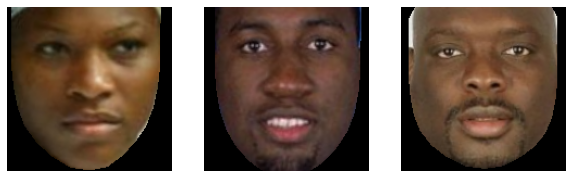

In [83]:
fig = plt.figure(figsize=(10,10))

test_set_2 = tf.Variable(tf.zeros((3,152,152,3)))

img1 = Image.open('./dataset/test/non-criminal/Serena_Williams_0034.bmp')
tens1 = tf.convert_to_tensor(img1, tf.float32)
test_set_2 = test_set_2[0].assign(img1)
fig.add_subplot(1,3,1)
plt.axis('off')
plt.imshow(img1)

img2 = Image.open('./dataset/test/non-criminal/Milt_Palacio_0001.bmp')
tens2 = tf.convert_to_tensor(img2, tf.float32)
test_set_2 = test_set_2[1].assign(img2)
fig.add_subplot(1,3,2)
plt.axis('off')
plt.imshow(img2)

img3 = Image.open('./dataset/test/non-criminal/Ted_Washington_0001.bmp')
tens3 = tf.convert_to_tensor(img3, tf.float32)
test_set_2 = test_set_2[2].assign(img3)
fig.add_subplot(1,3,3)
plt.axis('off')
plt.imshow(img3)

pred_1 = model.predict(tf.convert_to_tensor(test_set_2))#  tf.expand_dims(tens2, axis=0))
print(pred_1.reshape(-1))

# Dataset 2.0

Since the first execution of the architecture shows imbalanced predictions based on the ethnicity, we decide to feed the network with a balanced dataset, that considers a correct distribution of ethnicity and sex. To do so, we first studied the dataset in order to recongnize each visible bias to remove in this preliminary phase.

## Study of the dataset distribution

In [90]:
def func(x):
    if x.name == 'person': return x
    vals = x.values
    vals = [(1 if val > 0 else 0) for val in vals]
    return vals

In [92]:
df = pd.read_csv("./dataset/labels_utf8.csv")

df2 = pd.read_csv('./dataset/lfw_attributes.csv', delimiter='\t', header=[1])
column_interest = ['person', 'Male', 'Asian', 'White', 'Black']
df2 = df2[column_interest]
df5 = df2.apply(func)

### Sex distribution

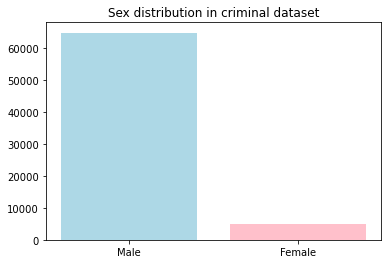

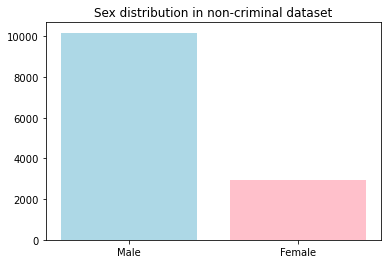

In [93]:
num_male_criminal = df[df['Sex'] == 'Male']['ID'].count()
num_female_criminal = df[df['Sex'] == 'Female']['ID'].count()

plt.figure()
plt.title('Sex distribution in criminal dataset')
plt.bar(['Male','Female'], [num_male_criminal, num_female_criminal], color=['lightblue', 'pink'])
plt.show()

num_male_non_criminal = df5[df5['Male'] == 1]['person'].count()
num_female_non_criminal = df5[df5['Male'] != 1]['person'].count()

plt.figure()
plt.title('Sex distribution in non-criminal dataset')
plt.bar(['Male','Female'], [num_male_non_criminal, num_female_non_criminal], color=['lightblue', 'pink'])
plt.show()

### Ethnicity distribution

In [94]:
ethnicity_criminals = {}
for ethnicity in df['Race'].unique():
    count = df[df['Race'] == ethnicity]['ID'].count()
    ethnicity_criminals[ethnicity] = count


ethnicity_non_criminals = {}

num_white_non_criminal = df5.loc[(df5['White'] == 1) & (df5['Black'] == 0) & (df5['Asian'] == 0)]['person'].count()
num_black_non_criminal = df5.loc[(df5['White'] == 0) & (df5['Black'] == 1) & (df5['Asian'] == 0)]['person'].count()
num_asian_non_criminal = df5.loc[(df5['White'] == 0) & (df5['Black'] == 0) & (df5['Asian'] == 1)]['person'].count()

ethnicity_non_criminals['White'] = num_white_non_criminal
ethnicity_non_criminals['Black'] = num_black_non_criminal
ethnicity_non_criminals['Asian'] = num_asian_non_criminal

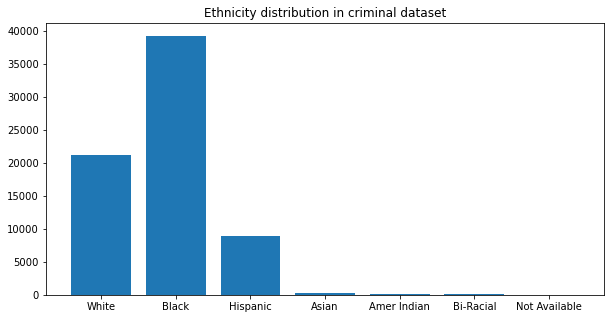

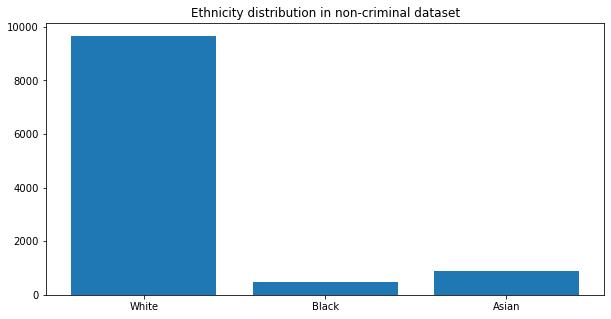

In [95]:
fig = plt.figure(figsize=(10,5))
plt.title('Ethnicity distribution in criminal dataset')
plt.bar(ethnicity_criminals.keys(), ethnicity_criminals.values())
plt.show()

plt.figure(figsize=(10,5))
plt.title('Ethnicity distribution in non-criminal dataset')
plt.bar(ethnicity_non_criminals.keys(), ethnicity_non_criminals.values())
plt.show()

### Sex-Ethinicity distribution in criminal dataset

In [96]:
sex_criminal = {}
for gender in ['Female', 'Male']:
    ethnicity_criminals = {}
    for ethnicity in df['Race'].unique():
        count = df.loc[(df['Race'] == ethnicity) & (df['Sex'] == gender)]['ID'].count()
        ethnicity_criminals[ethnicity] = count
    sex_criminal[gender] = ethnicity_criminals

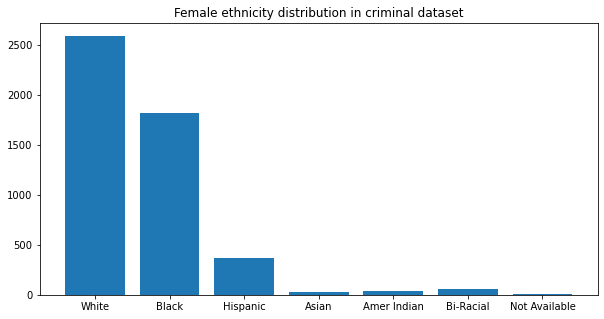

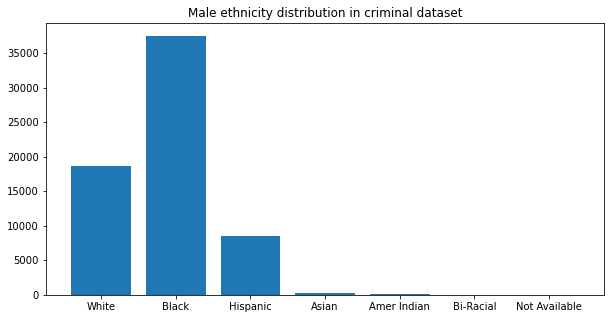

In [97]:
for gender in sex_criminal.keys():
    plt.figure(figsize=(10,5))
    plt.title(f'{gender} ethnicity distribution in criminal dataset')
    plt.bar(sex_criminal[gender].keys(), sex_criminal[gender].values())
    plt.show()

### Sex-Ethinicity distribution in non-criminal dataset

In [98]:
sex_non_criminal = {}

for gender in [1, 0]:
    ethnicity_non_criminals = {}

    num_white_non_criminal = df5.loc[(df5['Male'] == gender) & (df5['White'] == 1) & (df5['Black'] == 0) & (df5['Asian'] == 0)]['person'].count()
    num_black_non_criminal = df5.loc[(df5['Male'] == gender) & (df5['White'] == 0) & (df5['Black'] == 1) & (df5['Asian'] == 0)]['person'].count()
    num_asian_non_criminal = df5.loc[(df5['Male'] == gender) & (df5['White'] == 0) & (df5['Black'] == 0) & (df5['Asian'] == 1)]['person'].count()

    ethnicity_non_criminals['White'] = num_white_non_criminal
    ethnicity_non_criminals['Black'] = num_black_non_criminal
    ethnicity_non_criminals['Asian'] = num_asian_non_criminal

    sex_non_criminal[gender] = ethnicity_non_criminals

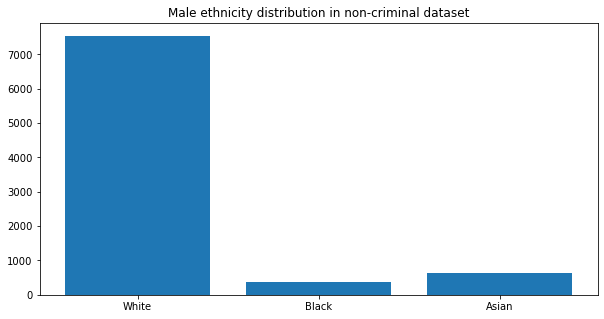

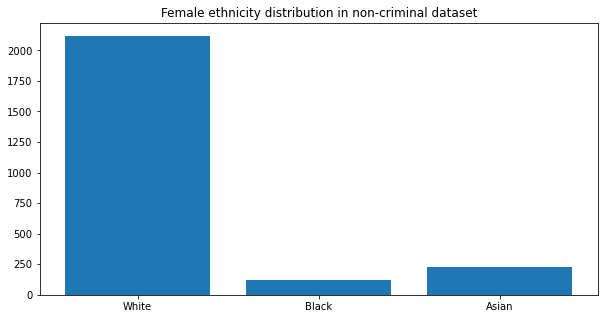

In [99]:
for gender in sex_non_criminal.keys():
    plt.figure(figsize=(10,5))
    plt.title(f'{"Male" if gender == 1 else "Female"} ethnicity distribution in non-criminal dataset')
    plt.bar(sex_non_criminal[gender].keys(), sex_non_criminal[gender].values())
    plt.show()

### Final dataset distribution

We decide to take only the white male and female, for a total of around 2000 images for both criminal and non-criminal datasets (50% female, 50% male) -> tot: 4000 images

## Load Final Dataset

In [5]:
batch_size = 4
image_size = (152, 152)
train_val_split = 0.2
data_dir = "./dataset/distributed/"

Load dataset from local folders

In [6]:
criminal_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

criminal_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

Found 3912 files belonging to 2 classes.
Using 3130 files for training.


2022-09-07 15:03:24.848230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 15:03:24.877422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 15:03:24.878356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 15:03:24.910952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3912 files belonging to 2 classes.
Using 782 files for validation.


# Architecure 2.0

The architecture is the same of Architecture 1.0 DeepFace, but now we use the balanced version of the dataset.

In [7]:
model = DeepFace()
optimizer = tf.keras.optimizers.SGD()  
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer, loss, metrics=['accuracy'])
model.build(input_shape=(4,152,152,3))

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=True)
callbacks = [early_stopping]

In [10]:
model.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=50, use_multiprocessing=True, workers=8, callbacks=callbacks)

Epoch 1/50


2022-09-07 15:06:03.530959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


783/783 [==============================] - 291s 216ms/step - loss: 0.6587 - accuracy: 0.6118 - val_loss: 0.5453 - val_accuracy: 0.7558
Epoch 2/50
783/783 [==============================] - 110s 141ms/step - loss: 0.4975 - accuracy: 0.7792 - val_loss: 0.4778 - val_accuracy: 0.8005
Epoch 3/50
783/783 [==============================] - 113s 144ms/step - loss: 0.3825 - accuracy: 0.8412 - val_loss: 0.2624 - val_accuracy: 0.8887
Epoch 4/50
783/783 [==============================] - 111s 141ms/step - loss: 0.2592 - accuracy: 0.8955 - val_loss: 0.4804 - val_accuracy: 0.8427
Epoch 5/50
783/783 [==============================] - 110s 140ms/step - loss: 0.2412 - accuracy: 0.9064 - val_loss: 0.5637 - val_accuracy: 0.7174
Epoch 6/50
783/783 [==============================] - 111s 142ms/step - loss: 0.2046 - accuracy: 0.9236 - val_loss: 0.2487 - val_accuracy: 0.9130
Epoch 7/50
783/783 [==============================] - 111s 141ms/step - loss: 0.1537 - accuracy: 0.9466 - val_loss: 0.2359 - val_accura

In [11]:
model.save_weights('./models/final_deep.h5')

# Evaluation

Now we test the model to understand its behaviour with new unseen samples.

1/1 [==============================] - 0s 70ms/step
[1.         0.9923212  0.13029867 0.81196827]


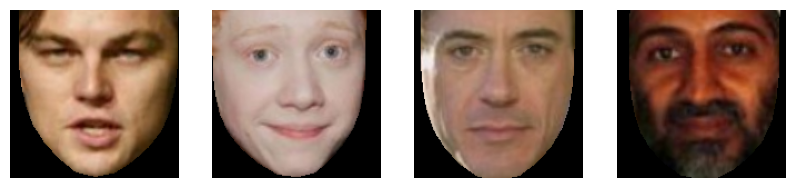

In [20]:
fig = plt.figure(figsize=(10,10))

test_set_1 = tf.Variable(tf.zeros((4,152,152,3)))

test_path = './deepcriminalfiles/dataset/test/'

img1 = Image.open(test_path + 'Leonardo_DiCaprio_0001.bmp')
img1 = np.array(img1)
tens1 = tf.convert_to_tensor(img1, tf.float32)
test_set_1 = test_set_1[0].assign(img1)
fig.add_subplot(1,4,1)
plt.axis('off')
plt.imshow(img1)

img2 = Image.open(test_path + 'Rupert_Grint_0003.bmp')
img2 = np.array(img2)
tens2 = tf.convert_to_tensor(img2, tf.float32)
test_set_1 = test_set_1[1].assign(img2)
fig.add_subplot(1,4,2)
plt.axis('off')
plt.imshow(img2)

img3 = Image.open(test_path + 'Robert_Downey_Jr_0001.bmp')
img3 = np.array(img3)
tens3 = tf.convert_to_tensor(img3, tf.float32)
test_set_1 = test_set_1[2].assign(img3)
fig.add_subplot(1,4,3)
plt.axis('off')
plt.imshow(img3)

img4 = Image.open(test_path + 'Osama_bin_Laden_0003.bmp')
img4 = np.array(img4)
tens4 = tf.convert_to_tensor(img4, tf.float32)
test_set_1 = test_set_1[3].assign(img4)
fig.add_subplot(1,4,4)
plt.axis('off')
plt.imshow(img4)

pred_1 = model.predict(tf.convert_to_tensor(test_set_1))#  tf.expand_dims(tens2, axis=0))
print(pred_1.reshape(-1))
plt.show()


The first three predictions are indeed correct, since the third person, Robert Downey Jr., has a criminal past. The last image, a notorious terrorist, is wrongly predicted, but maybe because the network has not seen this kind of ethnicity.

The following images of criminal are taken from: https://www.liverpoolecho.co.uk/news/liverpool-news/worst-worst-99-mugshots-merseysides-12393051

1/1 [==============================] - 0s 70ms/step
[('Anthony_Turner.bmp', 0.1339332), ('Jake_Hart.bmp', 0.018014256), ('David_McMullan.bmp', 0.0028624798), ('Luke_Kendrick.bmp', 0.045130916), ('Paul_Jenkins.bmp', 0.08276007), ('Samaya_Folksman.bmp', 0.47413582), ('woman.bmp', 0.67542726)]


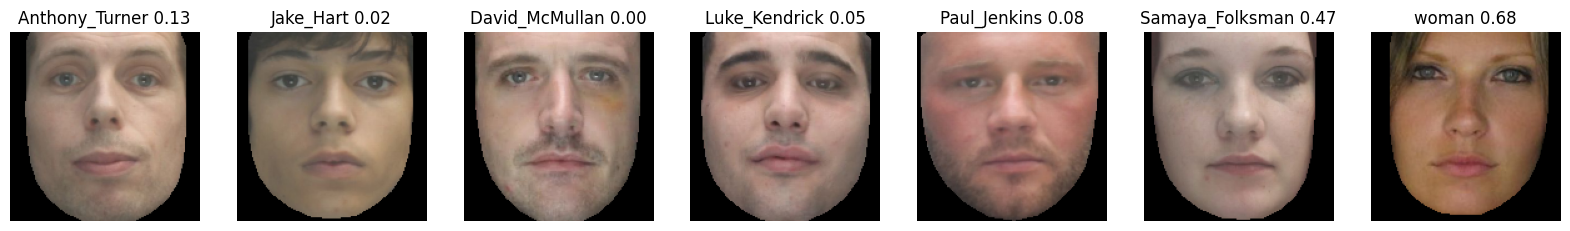

In [62]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.1, top=0.7)

test_set_criminals = tf.Variable(tf.zeros((7,152,152,3)))
test_path = './deepcriminalfiles/dataset/other_criminals/'
names = []
for i, file in enumerate(os.listdir(test_path)):
    names.append(file)
    img = Image.open(test_path + file)
    fig.add_subplot(1,7,i+1)
    plt.axis('off')
    plt.imshow(img)
    img = np.array(img)
    tens = tf.convert_to_tensor(img, tf.float32)
    pred = model.predict(tf.expand_dims(tens, axis=0))
    test_set_criminals = test_set_criminals[i].assign(img)
    plt.title(file.removesuffix('.bmp') + ' ' + '{:.2f}'.format(pred.item()))

pred_criminals = model.predict(tf.convert_to_tensor(test_set_criminals))#  tf.expand_dims(tens2, axis=0))
res = []
for n, p in zip(names, pred_criminals.reshape(-1)):
    res.append((n, p))
print(res)
plt.show()

The accuracy on this particular set is 86%, becuase only one image is wrongly classified (the last one)

1/1 [==============================] - 0s 70ms/step
[('lombardi.bmp', 0.76435095), ('milano.bmp', 0.77247167), ('patella.bmp', 0.96453786), ('chesani.bmp', 0.16395515), ('mello.bmp', 0.10306189), ('torroni.bmp', 0.8141467), ('distefano.bmp', 0.5407297)]


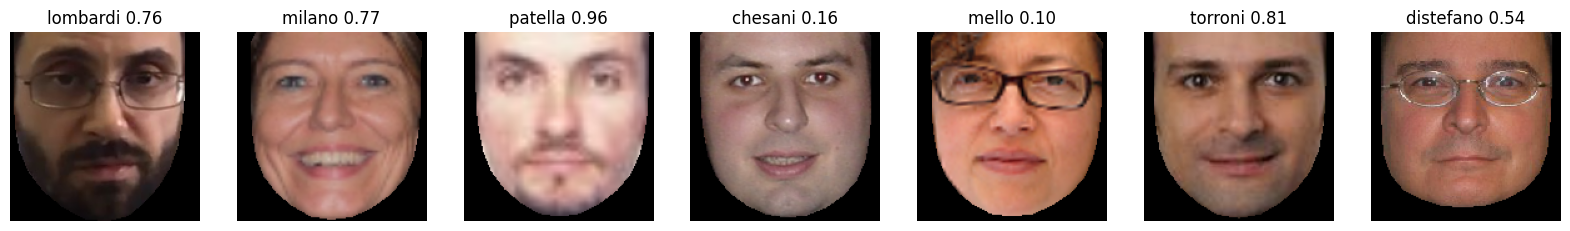

In [63]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.1, top=0.7)

test_set_prof = tf.Variable(tf.zeros((7,152,152,3)))
test_path = './deepcriminalfiles/dataset/prof/'
names = []
for i, file in enumerate(os.listdir(test_path)):
    names.append(file)
    img = Image.open(test_path + file)
    fig.add_subplot(1,7,i+1)
    plt.axis('off')
    plt.imshow(img)
    img = np.array(img)
    tens = tf.convert_to_tensor(img, tf.float32)
    pred = model.predict(tf.expand_dims(tens, axis=0))
    test_set_prof = test_set_prof[i].assign(img)
    plt.title(file.removesuffix('.bmp') + ' ' + '{:.2f}'.format(pred.item()))

pred_prof = model.predict(tf.convert_to_tensor(test_set_prof))#  tf.expand_dims(tens2, axis=0))
res = []
for n, p in zip(names, pred_prof.reshape(-1)):
    res.append((n, p))
print(res)
plt.show()

Here the accuracy is lower, around 72%, since two images are wrongly classified (the forth and the fifth)

After these initial experiment, we tested ourselves in different expression, with different accessories (glasses) and different light conditions

1/1 [==============================] - 0s 76ms/step
[('andrea_angry.bmp', 0.99857664), ('andrea_mid.bmp', 0.9998647), ('andrea.bmp', 1.7765959e-05), ('andrea_whatsapp.bmp', 0.9392819), ('andrea_happy.bmp', 0.99997187), ('andrea_serious.bmp', 0.99522674), ('andrea_glass.bmp', 8.395207e-05), ('andrea_camera.bmp', 0.98478436)]


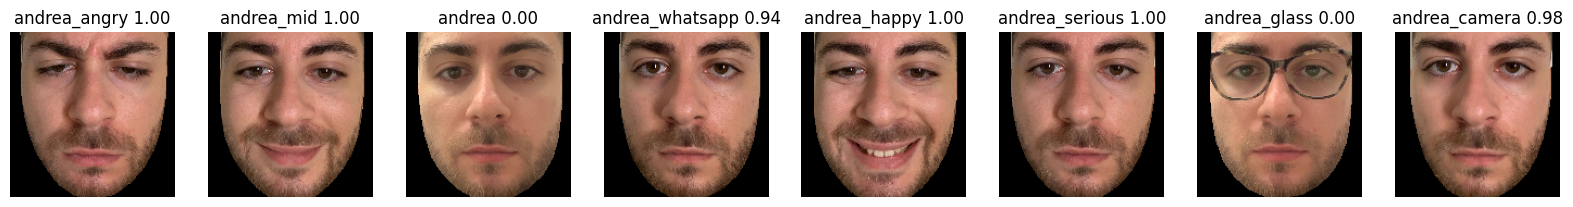

In [73]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.1, top=0.7)

test_set_andrea = tf.Variable(tf.zeros((8,152,152,3)))
test_path = './deepcriminalfiles/dataset/andrea/'
names = []
for i, file in enumerate(os.listdir(test_path)):
    names.append(file)
    img = Image.open(test_path + file)
    fig.add_subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(img)
    img = np.array(img)
    tens = tf.convert_to_tensor(img, tf.float32)
    pred = model.predict(tf.expand_dims(tens, axis=0))
    test_set_andrea = test_set_andrea[i].assign(img)
    plt.title(file.removesuffix('.bmp') + ' ' + '{:.2f}'.format(pred.item()))

pred_andrea = model.predict(tf.convert_to_tensor(test_set_andrea))#  tf.expand_dims(tens2, axis=0))
res = []
for n, p in zip(names, pred_andrea.reshape(-1)):
    res.append((n, p))
print(res)
plt.show()

# Explanation

## Shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

Reference paper: https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

In [12]:
def predict(img):
    output = model(img)
    return output

In [ ]:
import shap

topk = 4
batch_size = 50
n_evals = 10000

in_img = tf.convert_to_tensor(test_set_prof)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", in_img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=['criminal', 'non-criminal'])

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(in_img.numpy(), max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

In [70]:
# shap_values.data = shap_values.data[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]  # for one image: shap_values.values[0]

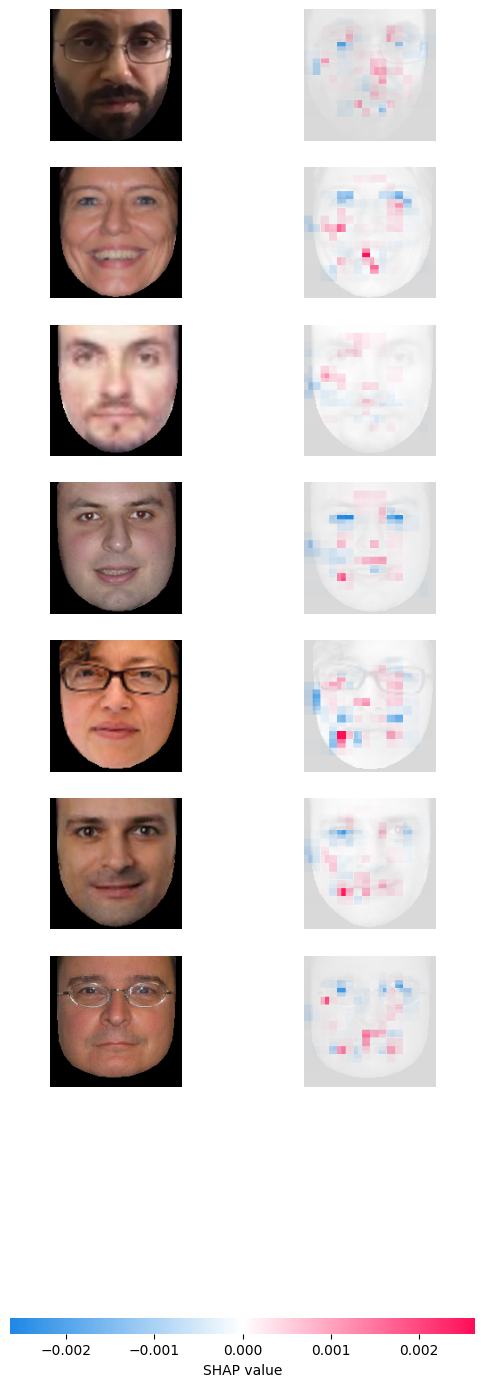

In [72]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data.astype(np.uint8))
                # labels=['criminal', 'non-criminal'])#,  # shap_values.output_names,
                # true_labels=['non-criminal'])

In [ ]:
import shap

topk = 4
batch_size = 50
n_evals = 10000

in_img = tf.convert_to_tensor(test_set_criminals)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", in_img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=['criminal', 'non-criminal'])

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(in_img.numpy(), max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

In [75]:
# shap_values.data = shap_values.data[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]  # for one image: shap_values.values[0]

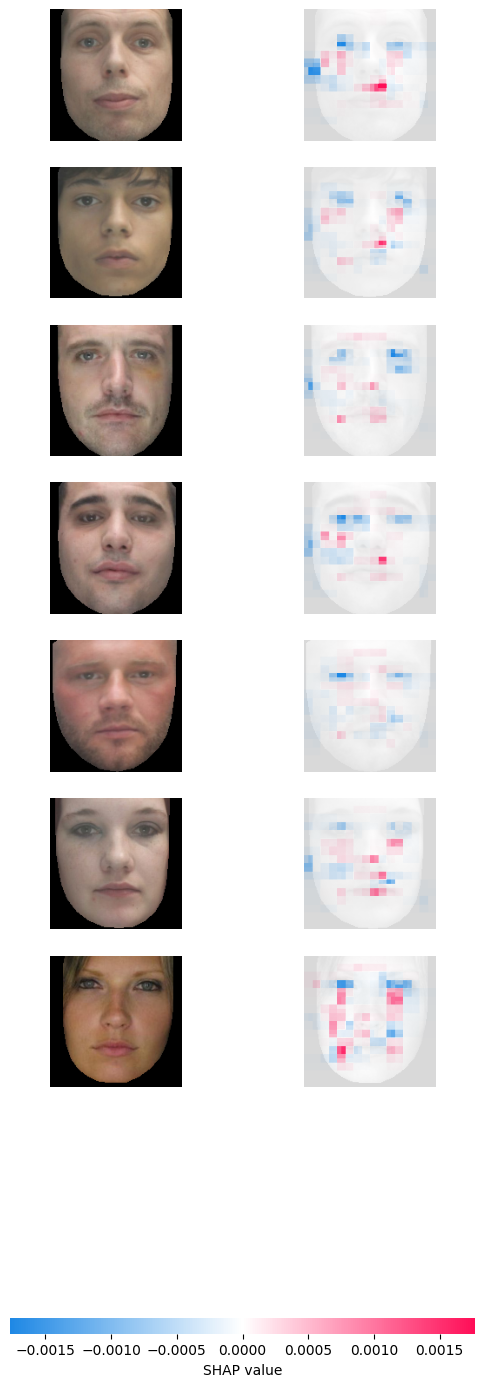

In [76]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data.astype(np.uint8))
                # labels=['criminal', 'non-criminal'])#,  # shap_values.output_names,
                # true_labels=['non-criminal'])

In [ ]:
import shap

topk = 4
batch_size = 50
n_evals = 10000

in_img = tf.convert_to_tensor(test_set_andrea)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", in_img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=['criminal', 'non-criminal'])

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(in_img.numpy(), max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

In [79]:
# shap_values.data = shap_values.data[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]  # for one image: shap_values.values[0]

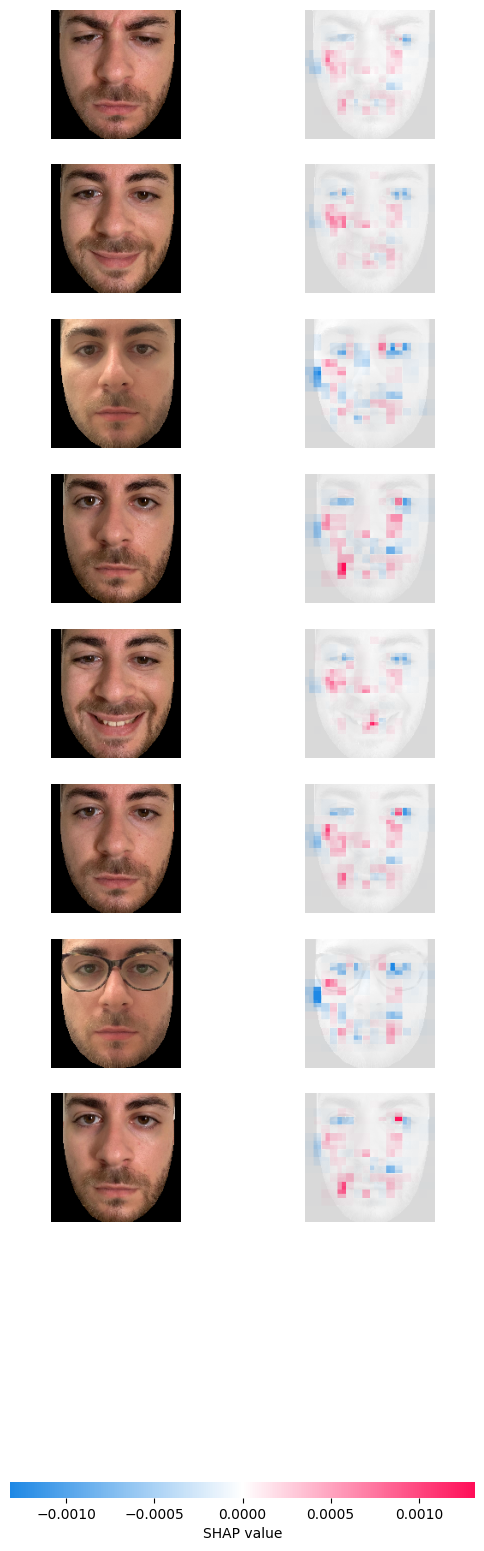

In [80]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data.astype(np.uint8))
                # labels=['criminal', 'non-criminal'])#,  # shap_values.output_names,
                # true_labels=['non-criminal'])

![title](images/highlighted_face.JPG)

It seems that there is something on the left of the image that lowered the global score (it tends to the criminal label), but we are not sure if it is the space between the face and the border or some incidental light or something that we cannot see by naked eye 

# Conclusions

At first sight, some predictions are quite impressive, since the network seems really to undestand some features. But, at closer look, we can conclude that:
- The test set is really small (14 images, accuracy 78%) and the images of criminals are mugshots
- The network is not robust at all to different light conditions
- There is the left side of the prediction that always lowered the score (that could be due to cropping phase, light conditions, something unknown...)

As future develops of this project, the following could be tested:
- A really balanced dataset with images taken from the same camera, with same background and light conditions
- Some brightness, contrast, noise and light augmentation could be done in the set to make the network more robust
- Define, also with expert of different fields, the concept of "non-criminal"
- Use a dataset that includes all the ethnicities

With all these suggestions, we believe that the work could drive forward the real disprove of the initial theory

# Final remarks

This is a toy-problem, we do not actually believe that the morality of a person could be judged only by the feature of his face 